<a href="https://colab.research.google.com/github/arkadijshmelev/Clothing_type_prediction/blob/master/Tensorflow_predicts_clothes_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Библиотеки

Установим необходимую версию

In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
import pandas as pd
import numpy as np
import sklearn
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

from warnings import filterwarnings
filterwarnings('ignore')

In [25]:
print(tf.__version__)
print(keras.__version__)

2.12.0
2.12.0


### Настройки

In [26]:
# Проверяем что у нас работает GPU.
tf.test.gpu_device_name()

'/device:GPU:0'

In [27]:
# Имя графического поцессора.
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-c4761685-3caf-cb5b-92bb-29f579c91246)


In [28]:
# Используем эту команду, чтобы увидеть активность графического
# процессора при выполнении задач глубокого обучения.
!nvidia-smi

Wed Aug  9 14:24:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    31W /  70W |   1659MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Данные

In [29]:
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.fashion_mnist.load_data()

In [30]:
# Посмотрим на данные.
print(x_train.shape)
print(x_val.shape)
print(y_train[:10])
print(y_val[:10])

(60000, 28, 28)
(10000, 28, 28)
[9 0 0 3 0 2 7 2 5 5]
[9 2 1 1 6 1 4 6 5 7]


Пример кусочка картинки (пиксели со значениями от 0 до 255):


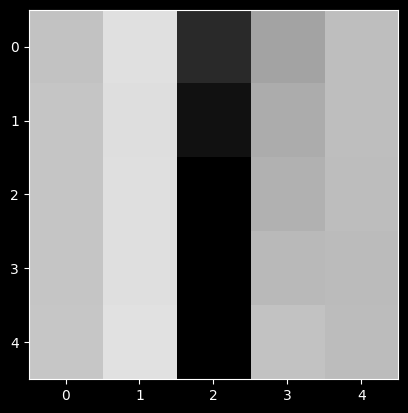

Пример картинки:


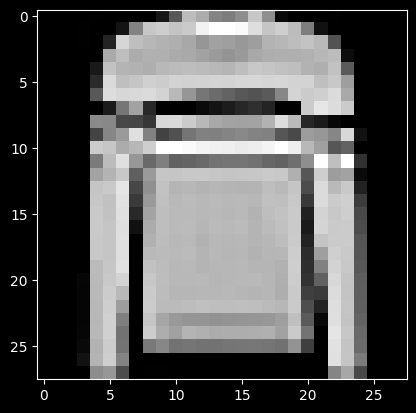

y_train [shape (60000,)] 10 примеров:
 [9 0 0 3 0 2 7 2 5 5]


In [31]:
# Нарисуем картинку.
x_train_image = np.tile(x_train[5, :, :].reshape((28, 28))[:, :, np.newaxis], (1, 1, 3))
print("Пример кусочка картинки (пиксели со значениями от 0 до 255):")
plt.imshow(x_train_image[15:20, 5:10], cmap="Greys")
plt.show()
print('Пример картинки:')
plt.imshow(x_train_image, cmap='Greys')
plt.show()
print('y_train [shape %s] 10 примеров:\n' % (str(y_train.shape)), y_train[:10])

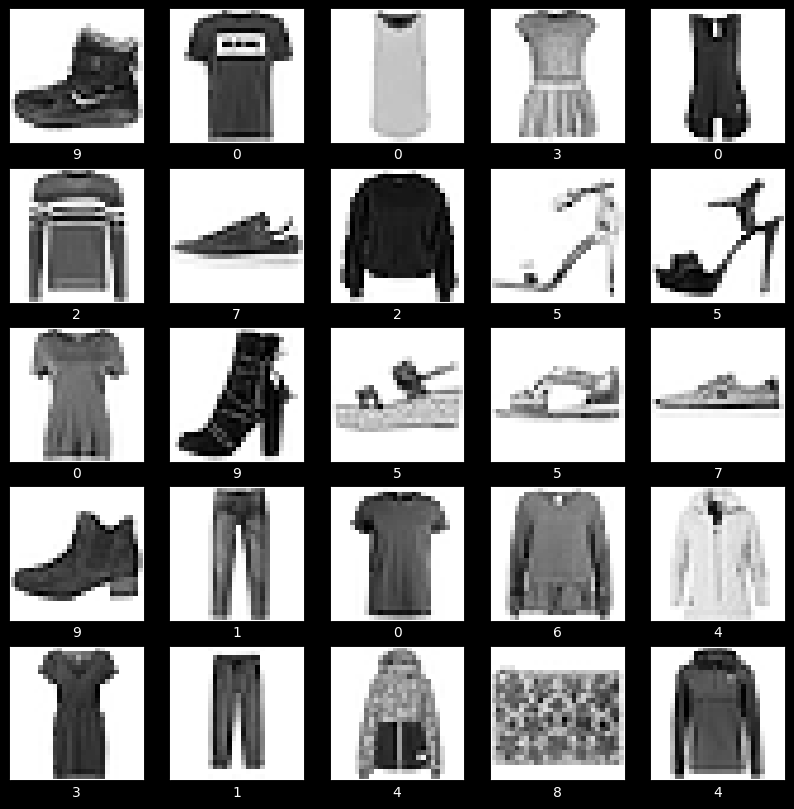

In [32]:
# Посмотрим побольше примеров.
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap='Greys')
    plt.xlabel(y_train[i])
plt.show()

In [33]:
# Вытянем картинку в вектор размера 28*28=784 и будем использовать это как признаки.
x_train_flat = x_train.reshape(-1, 28*28).astype(float)
print(x_train.shape, x_train_flat.shape)

x_val_flat = x_val.reshape(-1, 28*28).astype(float)
print(x_val.shape, x_val_flat.shape)

(60000, 28, 28) (60000, 784)
(10000, 28, 28) (10000, 784)


In [34]:
# Центрируем и нормируем, так сети будет проще учиться.
x_train_float = x_train_flat.astype(np.float) / 255 - 0.5
x_val_float = x_val_flat.astype(np.float) / 255 - 0.5

In [35]:
# Горячее кодирование для ответов.
y_train_oh = keras.utils.to_categorical(y_train, 10)
y_val_oh = keras.utils.to_categorical(y_val, 10)

print(y_train_oh.shape)
print(y_train_oh[:5], y_train[:5])

(60000, 10)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] [9 0 0 3 0]


### Собираем модель

In [36]:
# Для очистки памяти модели, чтобы она не доучивалась, а училась заново.
clear_session()

In [37]:
# Архитектура модели.
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(x_train_float.shape[1],))) # первый скрытый слой
model.add(Dense(128, activation='relu',)) # второй скрытый слой
model.add(Dense(10, activation='softmax',)) # выходной слой

In [38]:
# Для просмотра архитектуры модели.
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________


In [39]:
# Компилируем модель.
model.compile(
    loss='categorical_crossentropy',  # минимизируем кросс-энтропию
    optimizer='adam',  # так будет быстрее, позже узнаем что это :)
    metrics=['accuracy']  # выводим процент правильных ответов
)

In [40]:
# Обучаем модель.
history = model.fit(
                    x_train_float,
                    y_train_oh,
                    batch_size=64,  # 64 объекта для подсчета градиента на каждом шаге
                    epochs=20,  # 10 проходов по датасету
                    validation_data=(x_val_float, y_val_oh)
                    )

Epoch 1/20
938/938 [==============================] - 5s 4ms/step - loss: 0.4928 - accuracy: 0.8214 - val_loss: 0.4325 - val_accuracy: 0.8396
Epoch 2/20
938/938 [==============================] - 4s 4ms/step - loss: 0.3670 - accuracy: 0.8655 - val_loss: 0.3978 - val_accuracy: 0.8572
Epoch 3/20
938/938 [==============================] - 3s 4ms/step - loss: 0.3299 - accuracy: 0.8789 - val_loss: 0.3541 - val_accuracy: 0.8717
Epoch 4/20
938/938 [==============================] - 3s 4ms/step - loss: 0.3066 - accuracy: 0.8863 - val_loss: 0.3680 - val_accuracy: 0.8656
Epoch 5/20
938/938 [==============================] - 3s 3ms/step - loss: 0.2874 - accuracy: 0.8926 - val_loss: 0.3578 - val_accuracy: 0.8713
Epoch 6/20
938/938 [==============================] - 4s 5ms/step - loss: 0.2739 - accuracy: 0.8979 - val_loss: 0.3486 - val_accuracy: 0.8743
Epoch 7/20
938/938 [==============================] - 4s 4ms/step - loss: 0.2572 - accuracy: 0.9036 - val_loss: 0.3368 - val_accuracy: 0.8794
Epoch 

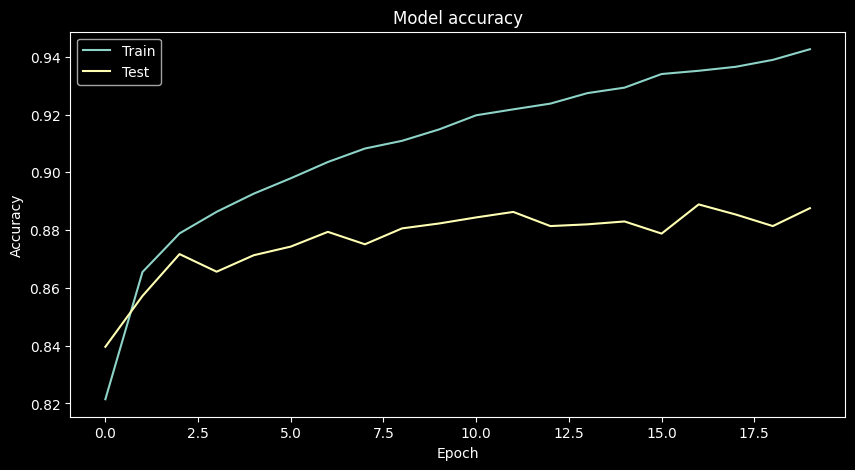

In [41]:
# Plot training & validation accuracy values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

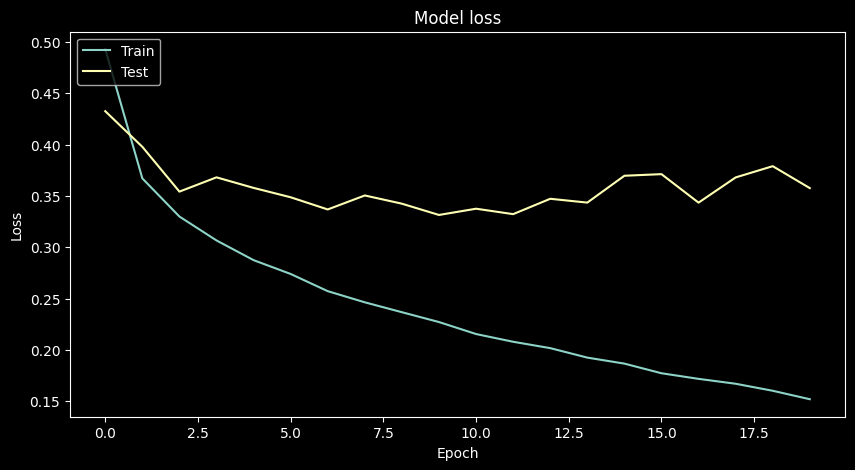

In [42]:
# Plot training & validation loss values
plt.style.use(['dark_background'])
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [43]:
# Делаем предсказание.
model.predict(x_val_float)

313/313 [==============================] - 1s 2ms/step


array([[6.32236104e-12, 3.92179648e-12, 1.49079078e-12, ...,
        1.10750017e-03, 1.04472075e-13, 9.98892248e-01],
       [5.59483533e-06, 3.14755343e-14, 9.99881148e-01, ...,
        9.55461767e-18, 9.04444840e-16, 3.60036350e-17],
       [4.05487960e-16, 1.00000000e+00, 9.05059032e-25, ...,
        8.36870134e-33, 6.47722695e-25, 2.27395242e-27],
       ...,
       [2.65611142e-08, 2.23906736e-13, 4.53863095e-07, ...,
        2.54165924e-11, 9.99999523e-01, 1.04262146e-11],
       [1.86787456e-12, 1.00000000e+00, 1.20807216e-15, ...,
        1.92510687e-19, 2.95602799e-16, 2.37537240e-15],
       [5.46998933e-07, 5.06505324e-11, 2.13677095e-06, ...,
        3.07226460e-03, 4.88413896e-08, 5.42461976e-06]], dtype=float32)

In [44]:
# Предсказываем классы: определяем номер класса,
# для которого вероятность принадлежности максимальна.
np.argmax(model.predict(x_val_float), axis = 1)

313/313 [==============================] - 0s 2ms/step


array([9, 2, 1, ..., 8, 1, 5])

In [45]:
# Считаем метрику.
predicts = np.argmax(model.predict(x_val_float), axis = 1)
print('Test Accuracy:', accuracy_score(y_val, predicts))

313/313 [==============================] - 0s 1ms/step
Test Accuracy: 0.8876
